In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import random
from torchvision import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import math
import torchvision
import skimage.io as io
from skimage.transform import rotate
from skimage.util import img_as_ubyte
from sklearn.metrics import accuracy_score, precision_score, f1_score

In [2]:
def augment_images(path):
    
    generated_imgs = 0
    imgs_augmntd = 0
    for img in os.listdir(path):
        try:
            image = io.imread(f'{os.path.join(path,img)}')

            #rotate images upto 360 degree

            for c in range(1,360,2):
                rotated = rotate(image,angle=c,mode='wrap')
                rotated_name = f'{img[:img.rfind(".")]}_r{c}'
                rotated_path =  os.path.join(path,f'{rotated_name}.jpg')
                io.imsave(fname = rotated_path,arr = img_as_ubyte(rotated))

                flipLR = np.fliplr(image)
                flipped_name = f'{rotated_name}_LR'
                flipped_path = os.path.join(path,f'{flipped_name}.jpg')
                io.imsave(fname = flipped_path,arr = img_as_ubyte(flipLR))

                flipUD = np.flipud(image)
                flipped_name = f'{rotated_name}_UD'
                flipped_path = os.path.join(path,f'{flipped_name}.jpg')
                io.imsave(fname = flipped_path, arr = img_as_ubyte(flipUD))

                generated_imgs += 3

                print(f'Images Augmented: {imgs_augmntd} | Images Generated: {generated_imgs}', end='\r')
        except:
            pass
            
        imgs_augmntd += 1
    
# augment_images('./data/no/')

In [2]:
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda")

In [3]:
class BrainDataset(Dataset):
    
    def get_image_data(self):
        img_data = [{'file': image, 'label': 1} for image in os.listdir(self.positive_dir)]
        img_data += [{'file': image, 'label': 0} for image in os.listdir(self.negative_dir)]
        return img_data
    
    def __init__(self,positive_dir, negative_dir,transform=None):
        super().__init__()
        self.positive_dir = positive_dir
        self.negative_dir = negative_dir
        self.image_data = self.get_image_data()
        self.transform = transform
        
    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        image_name =  self.image_data[idx]['file']
        img_label = torch.tensor([self.image_data[idx]['label']], dtype = torch.int64)
        img_dir = self.positive_dir if img_label == 1 else self.negative_dir
        img_path = os.path.join(img_dir, image_name)
        image = read_image(img_path)
        
        if image.size(0) == 1:
            image = image.expand(3,-1,-1)
            
        if self.transform:
            image = self.transform(image)
    
        return image, img_label, image_name
    

In [4]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.batch_norm = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,4)
        self.conv3 = nn.Conv2d(64,128,3) 
        self.conv4 = nn.Conv2d(128,128,2)
        
        self.fc1 = nn.Linear(128*14*14, 64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32, 2)    
        self.lr = nn.LeakyReLU()
        
    def forward(self,x):
        x = self.batch_norm(x)
        x = self.pool(self.lr(self.conv1(x)))
        x = self.pool(self.lr(self.conv2(x)))
        x = self.pool(self.lr(self.conv3(x)))
        x = self.pool(self.lr(self.conv4(x)))
        
        x = torch.flatten(x,1)

        x = self.lr(self.fc1(x))
        x = self.lr(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [5]:
data = BrainDataset('./data/yes/','./data/no/', transform = transforms.Compose([
                                                                            transforms.Resize((256,256)),
                                                                            lambda x: x/255.]))
size = len(data)
splits = (np.array([0.8, 0.19, 0.01])*size).astype('i')
splits[0] += size - splits.sum()

train_dataset, test_dataset, val_dataset = torch.utils.data.dataset.random_split(data, splits)

train_dataloader = DataLoader(train_dataset, batch_size=64, num_workers=0, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, num_workers=0, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=0, shuffle=True)

In [7]:
cnn = ConvNet()
cnn.to(device)

ConvNet(
  (batch_norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=25088, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (lr): LeakyReLU(negative_slope=0.01)
)

In [8]:
def metrics(predicted, true, summary, step):
    summary.add_scalar('scores/accuracy_score', accuracy_score(predicted, true), global_step=step)
    summary.add_scalar('scores/precision', precision_score(predicted, true), global_step=step)
    summary.add_scalar('scores/f1_score', f1_score(predicted, true), global_step=step)

In [9]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
writer = SummaryWriter(f'runs/cnn/{datetime.now().strftime("%Y%m%d_%H%M%S")}')

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=5e-4)#5e-4

epochs = 5

itr = 1
for epoch in range(epochs):
    cnn.train()
    print(f'\nEpoch: {epoch+1}')
 
    for images, labels, _ in train_dataloader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = cnn(images)
        loss = criterion(outputs, labels.squeeze())
        
        loss.backward()
        optimizer.step()
        
        del(images)
        del(labels)
        
        if itr % 100 == 0:
            preds, trues = [], []
            for i, j, _ in val_dataloader:
                pred = cnn.eval()(i.to(device))
                preds.append(F.softmax(pred, dim=1).detach().cpu().numpy().argmax(1))
                trues.append(j.detach().cpu().numpy().astype('i'))
            metrics(np.array(preds).flatten(), np.array(trues).flatten(), writer, itr)
        itr += 1
        print(f'Iter: {itr:10}', end='\r')
    torch.save({
            'epoch': epoch,
            'model_state_dict': cnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, os.path.join(os.getcwd(),'models',f'cnn_ckpt_{epoch}.pth')
    )
        
torch.save(cnn.state_dict(), os.path.join(os.getcwd(),'models','cnn_model.pth'))


Epoch: 1
Iter:       1462
Epoch: 2
Iter:       2923
Epoch: 3
Iter:       4384
Epoch: 4
Iter:       5845
Epoch: 5


In [6]:
cnn = ConvNet()
x = torch.load('./models/cnn_model.pth')
cnn.load_state_dict(x)

<All keys matched successfully>

In [10]:
img, label, _ = test_dataset[8000]
nn.functional.softmax(cnn.eval()(img[None]), dim=-1), label

(tensor([[1.7366e-13, 1.0000e+00]], grad_fn=<SoftmaxBackward>), tensor([1]))

Text(0.5, 0, 'Iterations (64 Images per Batch)')

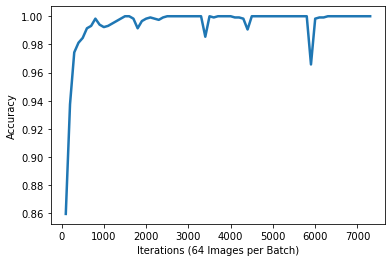

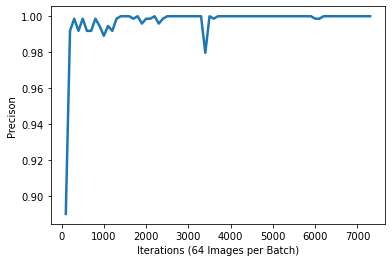

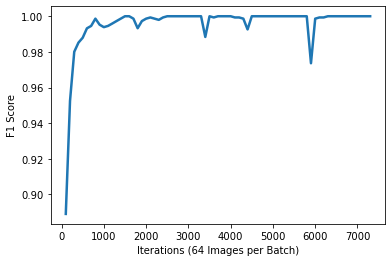

In [11]:
accuracy_score_csv = pd.read_csv('./scores/accuracy_score.csv').drop('Wall time',axis =1)
precision_score_csv = pd.read_csv('./scores/precision_score.csv').drop('Wall time',axis =1)
f1_score_csv = pd.read_csv('./scores/f1_score.csv').drop('Wall time',axis =1)

plot1 = plt.figure(1)
plt.plot(accuracy_score_csv['Step'].values,accuracy_score_csv['Value'].values,linewidth=2.5)
plt.ylabel('Accuracy')
plt.xlabel('Iterations (64 Images per Batch)')

plot2 = plt.figure(2)
plt.plot(precision_score_csv['Step'].values,precision_score_csv['Value'].values,linewidth=2.5)
plt.ylabel('Precison')
plt.xlabel('Iterations (64 Images per Batch)')

plot3 = plt.figure(3)
plt.plot(f1_score_csv['Step'].values,f1_score_csv['Value'].values,linewidth=2.5)
plt.ylabel('F1 Score')
plt.xlabel('Iterations (64 Images per Batch)')

In [7]:
def get_prediction(image_path):
    '''
    Returns the prediction for the given image
    '''
    
    img = read_image(image_path)/255.
    plt.imshow(img.permute(1,2,0).numpy())
    img = transforms.Resize((256,256))(img)
    img.to(device)
    
    res = nn.functional.softmax(cnn.eval()(img[None]), dim=-1).detach().cpu().numpy().flatten()
    
    return "Yes" if res.argmax() == 1 else "No"

'No'

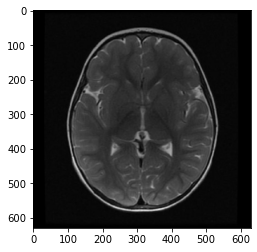

In [8]:
get_prediction("F:/Github/brain tumor detection/data/no/2 no_r165_LR.jpg")

'Yes'

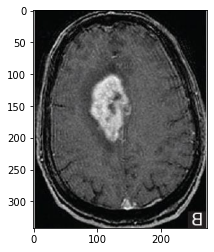

In [9]:
get_prediction("F:/Github/brain tumor detection/data/yes/Y192_r123_LR.jpg")